In [2]:
import torch
import rasterio
import numpy as np

In [3]:
from pathlib import Path

DATASET_DIR = Path("datasets")
BUILDING_DATASET_DIR = DATASET_DIR / "building_footprints"
SENTINEL_DATASET_DIR = DATASET_DIR / "sentinel"

In [4]:
from matplotlib import pyplot as plt

def normalize(img):
    masked_data = np.ma.masked_equal(img, 0)
    lq, uq = np.quantile(masked_data.compressed(), (0.01, 0.99))
    image_norm = np.clip(img, a_min=lq, a_max=uq)
    image_norm = (image_norm - lq) / (uq - lq)
    return image_norm

def vis(img, quant_norm=True):
    if quant_norm:
        data = normalize(img)
    else:
        data = img
    if data.ndim == 2:
        plt.imshow(data, cmap="gray")
    elif data.ndim == 3:
        plt.imshow(data)

    

(1548, 1665, 4)


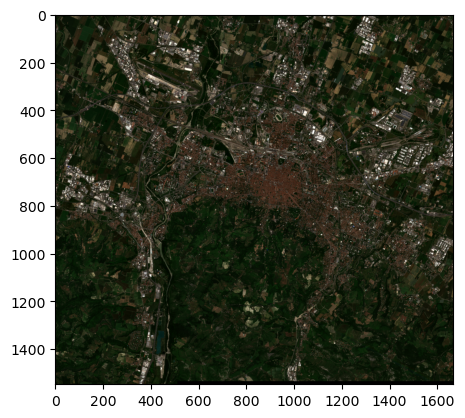

In [5]:
with rasterio.open(SENTINEL_DATASET_DIR / "bologna" / "R.tiff") as f:
    r_data = np.transpose(f.read(), (1,2,0)).squeeze()
with rasterio.open(SENTINEL_DATASET_DIR / "bologna" /  "G.tiff") as f:
    g_data = np.transpose(f.read(), (1,2,0)).squeeze()    
with rasterio.open(SENTINEL_DATASET_DIR / "bologna" /  "B.tiff") as f:
    b_data = np.transpose(f.read(), (1,2,0)).squeeze()
with rasterio.open(SENTINEL_DATASET_DIR / "bologna" /  "IR.tiff") as f:
    ir_data = np.transpose(f.read(), (1,2,0)).squeeze()

with rasterio.open(BUILDING_DATASET_DIR / "bologna" / "footprint.tiff") as f:
    building_data = np.transpose(f.read(), (1,2,0)).squeeze()


all_bands = np.stack([r_data, g_data, b_data, ir_data], axis=-1)
print(all_bands.shape)
all_bands = normalize(all_bands)
vis(all_bands[:,:,:3], quant_norm=False)

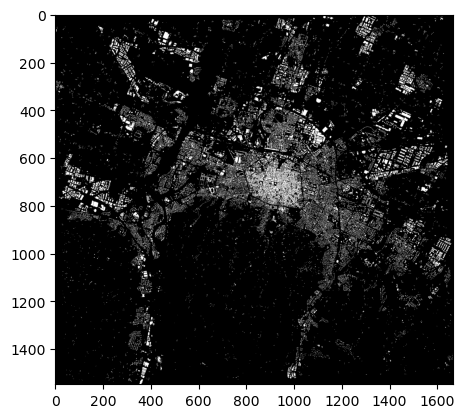

In [6]:
vis(building_data, quant_norm=False)

In [7]:
# Cloud classification

from sklearn.cluster import KMeans
stacked_data = np.stack([ir_data, r_data, g_data, b_data], axis=-1).reshape(-1, 4)
kmeans = KMeans(n_clusters=2, random_state=0).fit(stacked_data)
labels = kmeans.labels_.reshape(ir_data.shape)

cloud_label = kmeans.cluster_centers_[:, 0].argmax()
cloud_mask = labels == cloud_label

print(cloud_mask.shape)


# Add cloud mask to input_output_tensor
preprocess_data = np.dstack([all_bands, building_data, cloud_mask.astype(np.float32)])
preprocess_tensor = torch.from_numpy(preprocess_data)

(1548, 1665)


In [8]:
np.count_nonzero(preprocess_data[:,:,5] == 0)

13836

In [9]:
preprocess_tensor.size()

torch.Size([1548, 1665, 6])

torch.Size([48, 52, 32, 32, 6])
torch.Size([2496, 32, 32, 6])


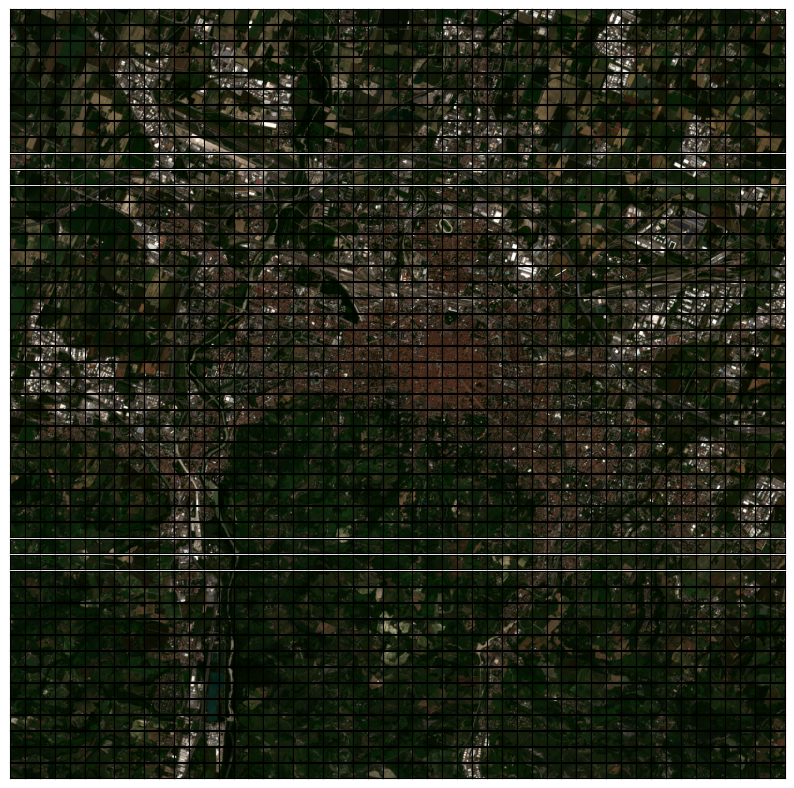

In [11]:
image_height, image_width = preprocess_tensor.size()[:2]

patch_size = 32

patches_grid = preprocess_tensor.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size).permute(0,1,3,4,2)
patches_num_x, patches_num_y = patches_grid.size()[:2]
print(patches_grid.size())
patches = patches_grid.flatten(start_dim=0, end_dim=1)
print(patches.size())

plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the patches in a grid
for x in range(patches_num_x):
    for y in range(patches_num_y):
        ax = plt.subplot(patches_num_x, patches_num_y, x*patches_num_y + y + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.axis("off")
        
        patch_rgb = patches_grid[x, y, :, :, :3]
        plt.imshow(patch_rgb)
        # plt.imshow(patches_grid[x, y, :, :, 4], cmap="gray")

torch.Size([1536, 1664, 6])


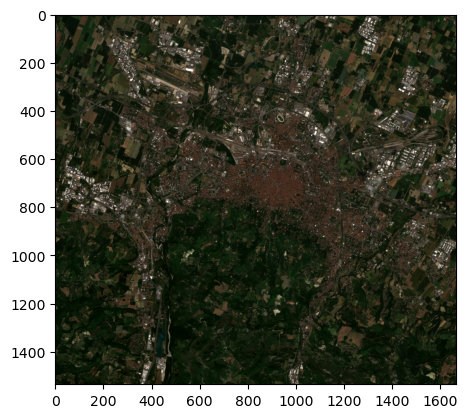

In [ ]:
# Test reconstruction
patches_grid_recon = patches.view(patches_num_x, patches_num_y, patch_size, patch_size, preprocess_tensor.size(2))
patches_grid_recon = patches_grid_recon.permute(0, 2, 1, 3, 4).contiguous()
patches_grid_recon = patches_grid_recon.view(patches_num_x * patch_size, patches_num_y * patch_size, preprocess_tensor.size(2))

print(patches_grid_recon.size())
vis(patches_grid_recon[:,:,:3], quant_norm=False)

In [12]:
def is_cloud_present(img):
    if np.count_nonzero(img[:,:,5] == False) > 0:
        return True
    return False

valid_patches = []
for i in range(len(patches)):
    if not is_cloud_present(patches[i]):
        valid_patches.append(i)
print(f"{len(valid_patches)}/{len(patches)} patches are valid")

2496/2496 patches are valid


In [67]:
from torch.utils.data import TensorDataset
input_tensor = patches[valid_patches, :, :, :3].permute(0,3,1,2) # change dims to (N, C, H, W)
output_tensor = patches[valid_patches, :, :, 4]
dataset = TensorDataset(input_tensor, output_tensor)

In [14]:
generator = torch.Generator().manual_seed(42)
train, test, val = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2], generator=generator)
len(train), len(test), len(val)

(1498, 499, 499)

In [60]:
train_output_tensor = dataset[train.indices][1]
print(train_output_tensor.size())
flattened = train_output_tensor.flatten()
print(flattened.size())
np.count_nonzero(flattened) / len(flattened)

torch.Size([1498, 32, 32])
torch.Size([1533952])


0.07863414239819759

In [74]:
from sklearn.model_selection import StratifiedShuffleSplit

output_tensor_flat = output_tensor.view(output_tensor.size(0), -1).mean(dim=1).numpy().round().astype(int)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(np.zeros(len(input_tensor)), output_tensor_flat):
    inputs_train, inputs_test = input_tensor[train_idx], input_tensor[test_idx]
    segments_train, segments_test = output_tensor[train_idx], output_tensor[test_idx]

In [75]:
inputs_train.size(), inputs_test.size(), segments_train.size(), segments_test.size()

(torch.Size([1996, 3, 32, 32]),
 torch.Size([500, 3, 32, 32]),
 torch.Size([1996, 32, 32]),
 torch.Size([500, 32, 32]))

In [ ]:
torch.save(train, 'torch/train.pt')
torch.save(val, 'torch/val.pt')
torch.save(test, 'torch/test.pt')

In [ ]:
image = TensorDataset(torch.from_numpy(np.expand_dims(all_bands[:,:,:3], 0)).permute(0,3,1,2), torch.from_numpy(np.expand_dims(building_data, 0)))
torch.save(image, 'torch/bologna.pt')